# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**Загружаем необходимые библиотеки и инструменты**

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import time

import warnings
warnings.filterwarnings('ignore')

**Загружаем датасет**

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
except:
    data = pd.read_csv('D:/Яндекс Практикум/16. Численные методы/autos.csv')

**Исследуем датасет и выполняем предобработку данных**

In [3]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [4]:
data.shape

(354369, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Типы столбцов корректны. Приводим название столбцов к правильному виду**

In [6]:
data = data.rename(columns={'DateCrawled': 'Date_Crawled',
    'VehicleType': 'Vehicle_Type',
    'RegistrationYear': 'Registration_Year',
    'RegistrationMonth': 'Registration_Month',
    'FuelType': 'Fuel_Type',
    'DateCreated': 'Date_Created',
    'NumberOfPictures': 'Number_Of_Pictures',
    'PostalCode': 'Postal_Code',
    'LastSeen': 'Last_Seen'                        
})

In [7]:
data.columns = data.columns.str.lower()

In [8]:
print(data.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


In [9]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
data.duplicated().sum()

4

In [11]:
data[data.duplicated(keep=False)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


**Обнаружено четыре дубликата. Удаляем их**

In [12]:
data = data.drop_duplicates()

In [13]:
data.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

**В пяти столбцах обнаружены пропуски. Изучим эти столбцы и подберём для каждого метод заполнения пропусков. Также изучим остальные признаки и при необходимости создадим новые**

**Изучим целевой признак - столбец `price` — цена (евро)**

In [14]:
data['price'].unique()

array([  480, 18300,  9800, ..., 12395, 18429, 10985], dtype=int64)

In [15]:
data['price'].value_counts().head()

0       10772
500      5670
1500     5394
1000     4648
1200     4594
Name: price, dtype: int64

In [16]:
print(len(data[data['price'] <= 0]))
print(len(data[data['price'] == 0]))
print(len(data[data['price'] <= 0]) * 100 / len(data))

10772
10772
3.03980359234123


**В столбце `price` обнаружено три процента нулевых значений. Так как цена не может быть нулевой удалим эти строки**

In [17]:
data = data[data['price'] > 0]

**Изучим столбец `model` — модель автомобиля**

In [18]:
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',
     

In [19]:
data['model'].value_counts()

golf                  28246
other                 23706
3er                   19179
polo                  12628
corsa                 12197
                      ...  
serie_2                   8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: model, Length: 250, dtype: int64

In [20]:
data['model'].isnull().sum()

17521

In [21]:
print(len(data[data['model'].isnull()]) * 100 / len(data), '% пропусков')

5.099347192754218 % пропусков


**Столбец `model` содержит 5% пропусков, заменим их значением 'other'**

In [22]:
data['model'] = data['model'].fillna('other')

**Изучим столбец `vehicle_type` — тип автомобильного кузова**

In [23]:
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [24]:
data['vehicle_type'].isnull().sum()

33750

In [25]:
print(len(data[data['vehicle_type'].isnull()]) * 100 / len(data), '% пропусков')

9.822668098593393 % пропусков


**Столбец `vehicle_type` содержит почти 10% пропусков, заменим их заглушкой 'unknown'**

In [26]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')

In [27]:
data.isnull().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox               17355
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             29459
brand                     0
repaired              65866
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [28]:
data['vehicle_type'].unique()

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

**Изучим столбец `registration_year` — год регистрации автомобиля**

In [29]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1959, 1956,
       3200, 1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957,
       1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 6500, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1934,
       1938, 1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931,
       4500, 1602, 7800, 1947, 1927, 7100, 8200, 1946], dtype=int64)

In [30]:
data['registration_year'].value_counts().head(60)

2000    23072
1999    21994
2005    21524
2006    19679
2001    19653
2003    19498
2004    19342
2002    18724
1998    17178
2007    17017
2008    15252
2009    14397
1997    13991
2010    10681
1996    10364
2017     9895
2011     9837
2016     8968
1995     8953
2012     7119
1994     4615
2013     4096
2018     3782
1993     3268
1992     2853
1991     2609
2014     2505
1990     2458
2015     1243
1989     1235
1988      903
1985      667
1987      627
1986      502
1980      490
1983      403
1984      382
1982      300
1970      284
1978      276
1979      267
1981      249
1972      210
1977      169
1974      167
1973      165
1971      159
1976      157
1975      137
1960      136
1969      117
1966      110
1968      105
1967       94
1965       80
1964       60
1910       56
1963       55
1962       40
1961       38
Name: registration_year, dtype: int64

**Выберем диапазон в 75 лет, который ограничит нижний порог возраста автомобиля 1941 годом, а верхний годом последней активности пользователя - 2016. Для этого создадим специальную функцию и посмотрим сколько объявлений не укладываются в этот диапазон.**

In [31]:
def count_out_of_range_values(data, column, start, end):
    count = 0
    for i in data[column]:
        if i < start or i > end:
            count += 1
    return count


count_ry = count_out_of_range_values(data, 'registration_year', 1941, 2016)
print(count_ry, 'строк')
print(count_ry * 100 / len(data), '% данных')

13938 строк
4.05654364320577 % данных


**Обнаружены аномальные значения. 4% данных выходят за выбранный нами диапазон - последние 75 лет. Так как выгрузка анкетных данных датируется 2016 годом, то даты позже этого года(большинство приходятся на 2017 и 2018 год) меняем на значение 2016. Оставшиеся 0,07% данных, которые соответствуют  значениям до 1941 года, удаляем.**

In [32]:
data.loc[data.registration_year.between(2017 ,2023), 'registration_year'] = 2016
count_ry1 = count_out_of_range_values(data, 'registration_year', 1941, 2016)
print(count_ry1, 'строк')
print(count_ry1 * 100 / len(data), '% данных')

245 строк
0.07130529434534463 % данных


In [33]:
data = data[(data['registration_year'] > 1940) & (data['registration_year'] < 2017)]

In [34]:
data.shape

(343348, 16)

**Изучим столбец `date_crawled` — дата скачивания анкеты из базы, параллельно создадим новые признаки - 'year_crawled' - год создания анкеты и 'month_crawled' - месяц создания анкеты**

In [35]:
data['year_crawled'] = pd.DatetimeIndex(data['date_crawled']).year
data['year_crawled'].unique()

array([2016], dtype=int64)

In [36]:
data['month_crawled'] = pd.DatetimeIndex(data['date_crawled']).month
data['month_crawled'].unique()

array([3, 4], dtype=int64)

**Столбец `date_crawled` содержит техническую информацию, которая не влияет на цену автомобиля, поэтому этот столбец удаляем.**

In [37]:
data = data.drop(['date_crawled', 'year_crawled', 'month_crawled'], axis=1)

**Изучим столбец `date_created` — дата создания анкеты, параллельно создадим новые признаки - 'year_created' - год создания анкеты и 'month_created' - месяц создания анкеты**

In [38]:
data['year_created'] = pd.DatetimeIndex(data['date_created']).year
data['year_created'].unique()

array([2016, 2015, 2014], dtype=int64)

In [39]:
data['month_created'] = pd.DatetimeIndex(data['date_created']).month
data['month_created'].unique()

array([ 3,  4,  2,  1, 11, 12,  9,  8,  6], dtype=int64)

**Изучим столбец `last_seen` — дата последней активности пользователя, параллельно создадим новые признаки - 'year_last_seen' - год последней активности пользователя и 'month_last_seen' - месяц последней активности пользователя**

In [40]:
data['year_last_seen'] = pd.DatetimeIndex(data['last_seen']).year
data['year_last_seen'].unique()

array([2016], dtype=int64)

In [41]:
data['month_last_seen'] = pd.DatetimeIndex(data['last_seen']).month
data['month_last_seen'].unique()

array([4, 3], dtype=int64)

**Столбец `month_last_seen` содержит техническую информацию, которая не влияет на цену автомобиля, поэтому этот столбец удаляем.**

In [42]:
data = data.drop(['last_seen', 'year_last_seen', 'month_last_seen'], axis=1)

In [43]:
pd.set_option('display.max_columns', None)
data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,year_created,month_created
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016,3
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016,3
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016,3
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016,3
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016,3
354365,2200,unknown,2005,NaN,0,other,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016,3
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016,3
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016,3


**Изучим столбец `gearbox` — тип коробки передач**

In [44]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [45]:
data['gearbox'].value_counts()

manual    261297
auto       64860
Name: gearbox, dtype: int64

In [46]:
data['gearbox'].isnull().sum()

17191

In [47]:
print(len(data[data['gearbox'].isnull()]) * 100 / len(data), '% пропусков')

5.006873492782833 % пропусков


**Столбец `gearbox` содержит 5% пропусков. Так как основная часть автомобилей в таблице оснащена механической коробкой передач - заменим пропуски значением 'manual'**

In [48]:
data['gearbox'] = data['gearbox'].fillna('manual')

**Изучим столбец `kilometer` — пробег (км)**

In [49]:
data['kilometer'].unique()

array([150000, 125000,  90000,  30000,  70000, 100000,  60000,   5000,
        20000,  80000,  50000,  40000,  10000], dtype=int64)

In [50]:
data['kilometer'].value_counts()

150000    230506
125000     35759
100000     14442
90000      11391
80000       9899
70000       8491
60000       7367
50000       6150
5000        5228
40000       4855
30000       4327
20000       3834
10000       1099
Name: kilometer, dtype: int64

**Аномалий в данном столбце не обнаружено**

**Изучим столбец `power` — мощность (л. с.)**

In [51]:
data['power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,   125,   101,
         105,   140,   115,   131,    60,   136,   160,   231,    90,
          50,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   280,   260,   104,   188,   333,   186,   117,   141,
          59,   132,   234,   158,    39,    92,    51,   135,   230,
          53,   209,

In [52]:
data['power'].value_counts()

0       36186
75      23317
60      15463
150     14169
101     12960
        ...  
2461        1
6006        1
5815        1
6018        1
1241        1
Name: power, Length: 699, dtype: int64

In [53]:
count_p = count_out_of_range_values(data, 'power', 0, 500)
print(count_p, 'строк')
print(count_p * 100 / len(data), '% данных')

419 строк
0.12203362186469704 % данных


In [54]:
data = data[data['power'] <= 500]

In [55]:
data['power'].value_counts()

0      36186
75     23317
60     15463
150    14169
101    12960
       ...  
428        1
337        1
331        1
489        1
377        1
Name: power, Length: 412, dtype: int64

In [56]:
print(len(data[data['power'] < 20]))
print(len(data[data['power'] < 20]) * 100 / len(data))

36574
10.665181422393557


In [57]:
mean_by_year_price_train = data.groupby(['kilometer', 'price'])['power'].mean()

data.loc[data['power'] < 20, 'power'] = data.loc[data['power'] < 20].apply(
    lambda row: mean_by_year_price_train[row['kilometer'], row['price']],
    axis=1
)
data['power'] = data['power'].astype(int)

In [58]:
print(len(data[data['power'] < 20]))
print(len(data[data['power'] < 20]) * 100 / len(data))

1047
0.30531101190042254


**В столбце `power` обнаружены аномальные значения. 0,12% строк содержат значения больше выбранного нами вернего порога в 500 л.с. Удалим эти строки. Более 10,5% строк содержат значения мощности меньше выбранного нами минимального порога в 20 л.с.. Эти строки исправим по среднему значению пробега и стоимости. Так как при этом тип столбца меняется на вещественный - исправим его на целочисленный. Оставшиеся неизменёнными 0,3% строк со значением мощности меньше 20 л.с. удалим**

In [59]:
data = data[data['power'] >= 20]

**Изучим столбец `registration_month` - месяц регистрации автомобиля**

In [60]:
data['registration_month'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

In [61]:
data['registration_month'].value_counts()

3     33724
0     32080
6     30751
4     28618
5     28461
7     26605
10    25545
12    23691
11    23690
9     23321
1     22562
8     22078
2     20756
Name: registration_month, dtype: int64

**Столбец `registration_month` содержит некорректные значения - около 10% строк содержат значение 0. Так как корректно исправить это мы не можем, оставим это столбец без изменений. Так как значения по месяцам не сильно отличаются в дальнейшем этот столбец возможно исключим из финальной таблицы для обучения моделей - посмотрим на коэффициент корреляции.**

**Изучим столбец `fuel_type` - тип топлива**

In [62]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [63]:
data['fuel_type'].value_counts()

petrol      210097
gasoline     96985
lpg           5160
cng            549
hybrid         227
other          157
electric        75
Name: fuel_type, dtype: int64

In [64]:
data['fuel_type'].isnull().sum()

28632

In [65]:
print(len(data[data['fuel_type'].isnull()]) * 100 / len(data), '% пропусков')

8.374819382125997 % пропусков


**Столбец `fuel_type` содержит 8,4% пропусков. Заполним их заглушкой 'unknown'**

In [66]:
data['fuel_type'] = data['fuel_type'].fillna('unknown')

**Изучим столбец `repaired` - была машина в ремонте или нет**

In [67]:
data['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [68]:
data['repaired'].value_counts()

no     243208
yes     33874
Name: repaired, dtype: int64

In [69]:
data['repaired'].isnull().sum()

64800

In [70]:
print(len(data[data['repaired'].isnull()]) * 100 / len(data), '% пропусков')

18.953908073545843 % пропусков


**Столбец `repaired` содержит 19% пропусков. Заполним их заглушкой 'unknown'**

In [71]:
data['repaired'] = data['repaired'].fillna('unknown')

**Изучим столбец `number_of_pictures` - количество фотографий автомобиля**

In [72]:
data['number_of_pictures'].unique()

array([0], dtype=int64)

**Столбец `number_of_pictures` содержит только одно значение - 0, поэтому его можно удалить из таблицы**

In [73]:
data = data.drop(['number_of_pictures'], axis=1)

In [74]:
data.isnull().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
postal_code           0
year_created          0
month_created         0
dtype: int64

**Нашим целевым признаком является столбец `gprice` - цена (евро). Изучим его соотношение с некоторыми основными признаками.**

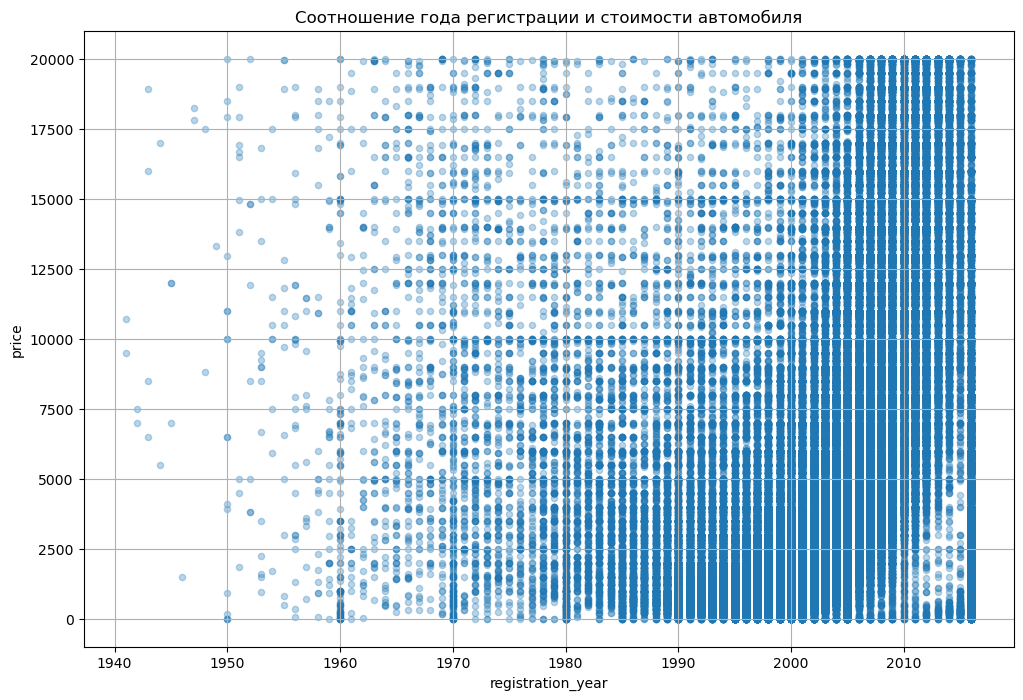

In [75]:
data.plot(x='registration_year', y='price', kind='scatter', alpha=0.3, grid=True, figsize=(12, 8),
          title='Соотношение года регистрации и стоимости автомобиля');

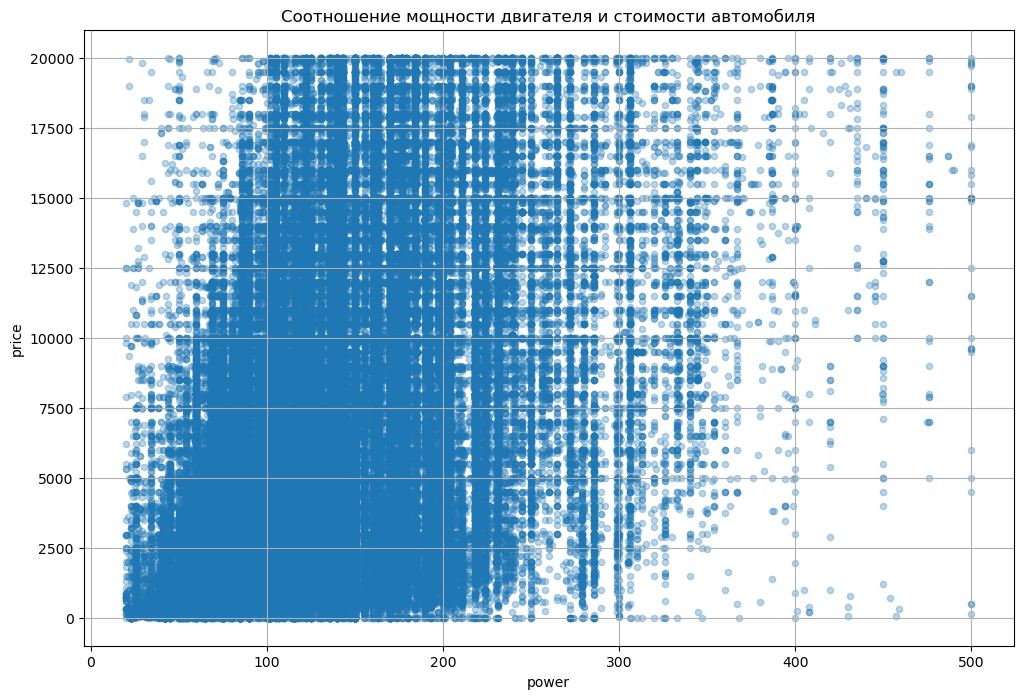

In [76]:
data.plot(x='power', y='price', kind='scatter', alpha=0.3, grid=True, figsize=(12, 8),
          title='Соотношение мощности двигателя и стоимости автомобиля');

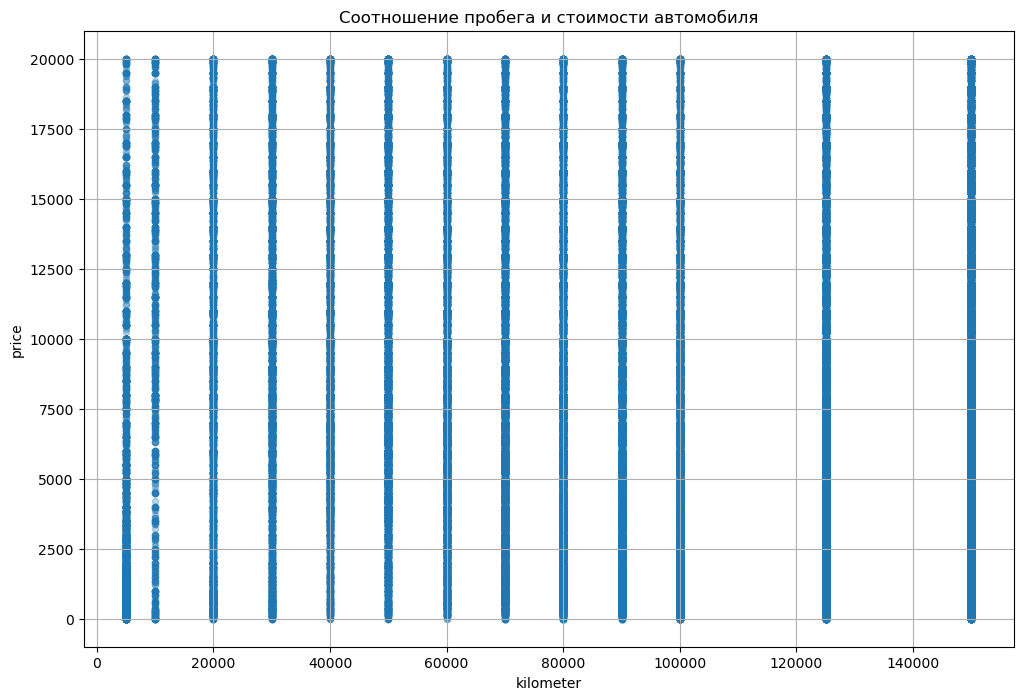

In [77]:
data.plot(x='kilometer', y='price', kind='scatter', alpha=0.3, grid=True, figsize=(12, 8),
          title='Соотношение пробега и стоимости автомобиля');

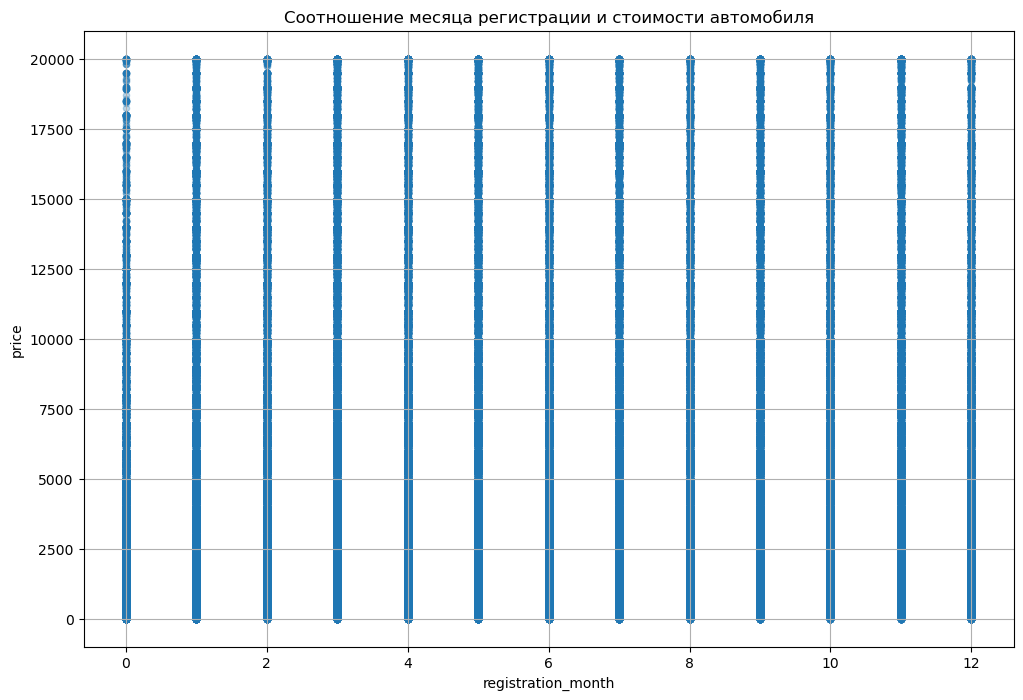

In [78]:
data.plot(x='registration_month', y='price', kind='scatter', alpha=0.3, grid=True, figsize=(12, 8),
          title='Соотношение месяца регистрации и стоимости автомобиля');

In [79]:
data.corr()[['price']].sort_values('price', ascending=False)

,price
price,1.000000
power,0.535178
registration_year,0.392178
registration_month,0.095537
postal_code,0.071461
month_created,0.014661
year_created,-0.005373
kilometer,-0.362070


In [80]:
data.corr()

,price,registration_year,power,kilometer,registration_month,postal_code,year_created,month_created
price,1.000000,0.392178,0.535178,-0.362070,0.095537,0.071461,-0.005373,0.014661
registration_year,0.392178,1.000000,0.117858,-0.208736,0.039060,0.022478,-0.000566,0.001814
power,0.535178,0.117858,1.000000,0.108732,0.077713,0.063267,-0.000918,0.003567
kilometer,-0.362070,-0.208736,0.108732,1.000000,-0.006538,-0.010663,0.004962,-0.002765
registration_month,0.095537,0.039060,0.077713,-0.006538,1.000000,0.009423,0.003556,-0.002530
postal_code,0.071461,0.022478,0.063267,-0.010663,0.009423,1.000000,0.000668,0.010142
year_created,-0.005373,-0.000566,-0.000918,0.004962,0.003556,0.000668,1.000000,-0.151512
month_created,0.014661,0.001814,0.003567,-0.002765,-0.002530,0.010142,-0.151512,1.000000


**На стоимость автомобиля наибольшее влияние имеют мощность двигателя, пробег автомобиля, и год регистрации автомобиля.**

**Признаки не дублируются. Между собой признаки слабо коррелируют, можно заметить только взаимовлияние года регистрации и пробега, и взаимовлияние года регистрации и мощности, что вполне объяснимо - чем старше машина, тем больше пробег, и мощность продаваемых автомобилей года от года растёт.**

**Данные изучены и обработаны, пропуски заполнены.**

In [81]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,year_created,month_created
0,480,unknown,1993,manual,69,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,70435,2016,3
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016,3
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,90480,2016,3
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016,3
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016,3


**Техникой TargetEncoding закодируем категориальные признаки**

In [82]:
cat_columns = data.loc[:,  (data.dtypes == 'object')].columns

In [83]:
target_enc = ce.TargetEncoder(cols=cat_columns)

In [84]:
target_enc.fit(data[cat_columns], data['price'])

TargetEncoder(cols=Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired',
       'date_created'],
      dtype='object'))

In [85]:
data_TE = data.join(target_enc.transform(data[cat_columns]).add_suffix('_target'))

In [86]:
data_TE = data_TE.drop(cat_columns, axis=1)

In [87]:
data_TE.corr()[['price']].sort_values('price', ascending=False)

,price
price,1.000000
power,0.535178
model_target,0.528883
registration_year,0.392178
vehicle_type_target,0.344454
brand_target,0.331964
fuel_type_target,0.307233
repaired_target,0.285212
gearbox_target,0.259802
registration_month,0.095537


**Категориальные признаки закодированы. Для уменьшения времени обучения моделей машинного обучения удалим признаки с коэффициентом корреляции менее 0,1**

In [88]:
data_TE = data_TE.drop(['year_created', 'month_created', 
                        'date_created_target', 'postal_code', 'registration_month'], axis=1)

In [89]:
data_TE

,price,registration_year,power,kilometer,vehicle_type_target,gearbox_target,model_target,fuel_type_target,brand_target,repaired_target
0,480,1993,69,150000,2671.289389,3997.933022,4303.595263,3849.243773,4542.151778,2856.162299
1,18300,2011,190,125000,6205.752582,3997.933022,4032.328805,6687.994690,6442.943994,2025.140196
2,9800,2004,163,125000,9171.639976,6992.201299,6440.798561,6687.994690,7287.259542,2856.162299
3,1500,2001,75,150000,2742.758683,3997.933022,4303.595263,3849.243773,4542.151778,5372.918806
4,3600,2008,69,90000,2742.758683,3997.933022,4225.628405,6687.994690,5992.964721,5372.918806
...,...,...,...,...,...,...,...,...,...,...
354363,1150,2000,82,150000,5573.564378,3997.933022,3768.990946,3849.243773,2832.827973,5372.918806
354365,2200,2005,72,20000,2671.289389,3997.933022,4032.328805,2652.157132,6168.748882,2856.162299
354366,1199,2000,101,125000,6923.324568,6992.201299,3635.506539,3849.243773,3544.288988,5372.918806
354367,9200,1996,102,150000,5573.564378,3997.933022,6934.425596,6687.994690,4542.151778,5372.918806


**Разделим данные на целевой и обучающие признаки, а также на тренировочную и тестовую выборки**

In [90]:
features = data_TE.drop(['price'], axis=1)
target = data_TE['price']

In [91]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42) 

In [92]:
features_train.head()

,registration_year,power,kilometer,vehicle_type_target,gearbox_target,model_target,fuel_type_target,brand_target,repaired_target
69249,2003,59,125000,5573.564378,3997.933022,1923.731765,3849.243773,2832.827973,2025.140196
137761,2006,207,5000,4831.214937,6992.201299,4032.328805,6687.994690,6816.210634,2025.140196
46215,2016,107,150000,2671.289389,6992.201299,9484.622318,6687.994690,6047.439338,2025.140196
96973,1989,165,150000,4994.163605,3997.933022,1875.078481,3849.243773,6442.943994,5372.918806
28627,2012,122,40000,6923.324568,6992.201299,4303.595263,3849.243773,4542.151778,5372.918806


In [93]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(256411, 9)
(256411,)
(85471, 9)
(85471,)


##   Обучение моделей

**Согласно задаче нам необходимо подобрать мордель обучения, которая будет иметь высокое качество предсказания, высокую скорость предсказания и малое время обучения. Оптимальную модель будем выбирать из следующих - Дерево решений, Случайный лес, LightGBM и CatBoost. Обучим каждую из этих моделей и сравним интересующие нас показатели. Метрика качества - RMSE.**

**Модель Дерево решений**

In [94]:
start_time_dt = time.perf_counter()

param_grid_dt = {
    'max_depth': [10, 11, 12, 13, 14, 15, 16]
}

dt_estimator = DecisionTreeRegressor(random_state=42)

gsearch = GridSearchCV(
    estimator=dt_estimator,
    param_grid=param_grid_dt,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

dt_model = gsearch.fit(features_train, target_train)

best_params_dt = dt_model.best_params_
best_score_dt = -dt_model.best_score_

end_time_dt = time.perf_counter()
execution_time_dt = end_time_dt - start_time_dt

print('Оптимальные параметры:', best_params_dt)
print('RMSE модели:', best_score_dt**0.5)
print('Время обучения: {:.2f} секунд'.format(execution_time_dt))

Оптимальные параметры: {'max_depth': 14}
RMSE модели: 1835.396729489956
Время обучения: 13.33 секунд


**Модель Случайный лес**

In [95]:
start_time_rf = time.perf_counter()

rf_param = {
    'n_estimators': [30, 35],
    'max_depth': [25, 30]
}

rf_gs = GridSearchCV(RandomForestRegressor(random_state=42, criterion='friedman_mse'),
                     rf_param, 
                     cv = 5, 
                     scoring = 'neg_mean_squared_error', 
                     n_jobs=-1)

rf_model = rf_gs.fit(features_train, target_train)

best_params_rf = rf_model.best_params_
best_score_rf = -rf_model.best_score_

end_time_rf = time.perf_counter()
execution_time_rf = end_time_rf - start_time_rf

print('Оптимальные параметры:', best_params_rf)
print('RMSE модели:', best_score_rf**0.5)
print('Время обучения: {:.2f} секунд'.format(execution_time_rf))

Оптимальные параметры: {'max_depth': 25, 'n_estimators': 35}
RMSE модели: 1583.8895362678866
Время обучения: 211.48 секунд


**Модель градиентного бустинга LightGBM**

In [96]:
start_time_lgb = time.perf_counter()

param_grid = {
    'num_leaves': [71, 81],
    'learning_rate': [0.1, 1.5]
}

lgb_estimator = lgb.LGBMRegressor(task='train', boosting_type='gbdt', objective='regression', verbose=-1)

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, 
                       scoring = 'neg_mean_squared_error', cv=5, n_jobs=-1)
lgb_model = gsearch.fit(features_train, target_train)

best_params_lgb = lgb_model.best_params_
best_score_lgb = -lgb_model.best_score_

end_time_lgb = time.perf_counter()
execution_time_lgb = end_time_lgb - start_time_lgb

print('Лучшие параметры:', best_params_lgb)
print('RMSE модели:', best_score_lgb**0.5)
print('Время обучения: {:.2f} секунд'.format(execution_time_lgb))

Лучшие параметры: {'learning_rate': 0.1, 'num_leaves': 81}
RMSE модели: 1606.1106018666553
Время обучения: 25.33 секунд


**Модель градиентного бустинга CatBoost**

In [97]:
start_time_cb = time.perf_counter()

cb_model = CatBoostRegressor()

param_grid = {
    'learning_rate': [0.15, 0.2],
    'depth': [8],
    'iterations': [200, 300]
}

grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

end_time_cb = time.perf_counter()
execution_time_cb = end_time_cb - start_time_cb

print('Лучшие параметры:', best_params)
print('RMSE модели:', best_score**0.5)
print('Время обучения: {:.2f} секунд'.format(execution_time_cb))

0:	learn: 3893.9461427	total: 177ms	remaining: 52.8s
1:	learn: 3421.5227805	total: 208ms	remaining: 31s
2:	learn: 3044.3693893	total: 237ms	remaining: 23.5s
3:	learn: 2762.1107176	total: 266ms	remaining: 19.7s
4:	learn: 2549.6017081	total: 291ms	remaining: 17.2s
5:	learn: 2377.8857880	total: 317ms	remaining: 15.5s
6:	learn: 2259.4609380	total: 344ms	remaining: 14.4s
7:	learn: 2159.6908891	total: 370ms	remaining: 13.5s
8:	learn: 2089.2005745	total: 401ms	remaining: 13s
9:	learn: 2029.0980664	total: 431ms	remaining: 12.5s
10:	learn: 1986.0028123	total: 456ms	remaining: 12s
11:	learn: 1948.9469394	total: 482ms	remaining: 11.6s
12:	learn: 1922.1769280	total: 510ms	remaining: 11.3s
13:	learn: 1898.2792147	total: 534ms	remaining: 10.9s
14:	learn: 1880.2070354	total: 559ms	remaining: 10.6s
15:	learn: 1864.7655115	total: 584ms	remaining: 10.4s
16:	learn: 1849.9079945	total: 610ms	remaining: 10.1s
17:	learn: 1834.8261551	total: 639ms	remaining: 10s
18:	learn: 1825.3823861	total: 668ms	remaining

## Анализ моделей

In [98]:
dt_results = pd.DataFrame({
    'Модель': ['Дерево решений'],
    'RMSE модели': [best_score_dt**0.5],
    'Время обучения, сек.': [execution_time_dt]
})

rf_results = pd.DataFrame({
    'Модель': ['Случайный лес'],
    'RMSE модели': [best_score_rf**0.5],
    'Время обучения, сек.': [execution_time_rf]
})

lgb_results = pd.DataFrame({
    'Модель': ['LightGBM'],
    'RMSE модели': [best_score_lgb**0.5],
    'Время обучения, сек.': [execution_time_lgb]
})

cb_results = pd.DataFrame({
    'Модель': ['CatBoost'],
    'RMSE модели': [best_score**0.5],
    'Время обучения, сек.': [execution_time_cb]
})

results = pd.concat([dt_results, rf_results, lgb_results, cb_results], ignore_index=True)
results = results.style.hide_index()
results

Модель,RMSE модели,"Время обучения, сек."
Дерево решений,1835.396729,13.327792
Случайный лес,1583.889536,211.481933
LightGBM,1606.110602,25.329002
CatBoost,1586.182194,104.562512


In [99]:
importance = gsearch.best_estimator_.feature_importances_

In [100]:
feature_importance_df = pd.DataFrame({'Признак': features_train.columns, 'Важность': importance})

In [101]:
feature_importance_df = feature_importance_df.sort_values(by='Важность', ascending=False)

In [102]:
feature_importance_df

,Признак,Важность
1,power,1899
0,registration_year,1652
5,model_target,1314
7,brand_target,1035
2,kilometer,761
3,vehicle_type_target,696
6,fuel_type_target,282
8,repaired_target,271
4,gearbox_target,90


**По важности в выбранной модели признаки распределились вполне предсказуемо.**

**Проверим качество модели градиентного бустинга LightGBM, которая показала лучшее соотношение скорость обучения/качество, по предсказанием на тестовой выборке**

In [103]:
start_time_lgbp = time.perf_counter()

best_model_lgb = lgb.LGBMRegressor(**best_params_lgb)

best_model_lgb.fit(features_train, target_train)

predict_lgb = best_model_lgb.predict(features_test)

end_time_lgbp = time.perf_counter()
execution_time_lgbp = end_time_lgbp - start_time_lgbp

print('RMSE предсказания', mean_squared_error(target_test, predict_lgb)**0.5)
print('Время предсказания: {:.2f} секунд'.format(execution_time_lgbp))

RMSE предсказания 1616.3887043230948
Время предсказания: 1.32 секунд


In [104]:
lrt_results = pd.DataFrame({
    'RMSE модели': [best_score_dt**0.5],
    'Время обучения, сек.': [execution_time_dt],
    'RMSE предсказания': [mean_squared_error(target_test, predict_lgb)**0.5],
    'Время предсказания': [execution_time_lgbp]
})

lrt_results

,RMSE модели,"Время обучения, сек.",RMSE предсказания,Время предсказания
0,1835.396729,13.327792,1616.388704,1.322978


**Наилучшее качество обучения показала модель Случайный лес	, но по времени обучения она сильно уступает остальным моделям. Лучшая метрика RMSE у модели Случайный лес, затем по убыванию качества идут модели, CatBoost, LightGBM, Дерево решений. Случайный лес - самая долгая модель, но с лучшими показателями качества.**

**По соотношению всех показателей первое место занимает занимает модель LightGBM.**